In [1]:
from colormath import color_objects, color_conversions
import os
import sys
import pandas as pd
import matplotlib
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tqdm

# Get relatives
sys.path.append('/Users/benpeloquin/Desktop/Projects/world_color_survey/')
sys.path.append('/Users/benpeloquin/Desktop/Projects/world_color_survey/data')
import utils
from data import data

%matplotlib inline

In [2]:
def normalize_rows(M):
    """Noramlze across columns (rows sum to 1)"""
    total = np.sum(M, axis=1)
    return (M.transpose() / total).transpose()

def normalize_cols(M):
    """Normalize down rows (columns sum to 1)"""
    total = np.sum(M, axis=0)
    return M / total

def rsa_speaker(M, depth=0):
    M_ = normalize_cols(M)
    for d in range(depth):
        M_ = normalize_cols(normalize_rows(M_))
    return M_
        
def rsa_listener(M, depth=0):
    M_ = normalize_rows(M)
    for d in range(depth):
        M_ = normalize_rows(normalize_cols(M_))
    return M_

In [8]:
fp = '../data/merged_wcs_data.csv'
df_raw = pd.read_csv(fp)

In [9]:
df_agg = df_raw[['lang_num', 'term_abbr', 'chip_num', 'speaker_num']] \
    .groupby(['lang_num', 'term_abbr', 'chip_num']) \
    .sum() \
    .rename(columns={'speaker_num': 'cnt'}) \
    .reset_index()

Gibson 2017 analysis:
$$S(c) = \sum_w p(w|c)log_2(\frac{1}{p(c|w)})$$
$$ES = \sum_c p(c)S(c)$$

In [10]:
def get_term_chip_cnt(term, chip, df):
    vals = df[(df['term_abbr'] == term) & (df['chip_num'] == chip)]['cnt'].values
    if len(vals) != 0:
        return vals[0]
    else:
        return 0
    
def create_count_df(lang_num, df):
    """Full df to filtered lang_num df to counts df."""
    df_cnts = df[df['lang_num'] == lang_num][['speaker_num', 'term_abbr', 'chip_num']] \
        .groupby(['term_abbr', 'chip_num']) \
        .sum() \
        .rename(columns={'speaker_num': 'cnt'}) \
        .reset_index()
    return df_cnts
    
def create_term_chip_matrix(lang_num):
    """Create a term-chip raw count matrix.
    
    Term X Chip matrix
    
    Returns
    -------
    tuple of np.array, list, list
        Matrix, terms, chips
    """
    df_curr = df_agg[df_agg['lang_num'] == lang_num]
    terms = set(df_curr['term_abbr'].values)
    chips = set(df_curr['chip_num'].values)
    d_res = []
    for term in terms:
        curr_row = [get_term_chip_cnt(term, chip, df_curr) for chip in chips]
        d_res.append(curr_row) 
    return np.array(d_res), terms, chips

In [11]:
M1, terms1, chips1 = create_term_chip_matrix(1)

In [12]:
M1_speaker = normalize_cols(M1)
M1_listener = normalize_rows(M1)

In [13]:
def log2_(v):
    return np.log2(v) if v != 0. else 0.

def p_c_given_w(M_listener, w, c):
    assert abs(np.sum(M_listener[w, :]) - 1.) < 1e-05
    return M_listener[w, c]

def p_w_given_c(M_speaker, w, c):
    assert abs(np.sum(M_speaker[:, c]) - 1.) < 1e-05
    return M_speaker[w, c]

def s_c(M_listener, M_speaker, c):
    assert M_listener.shape == M_speaker.shape
    res = []
    for w in range(M_speaker.shape[0]):
        d = p_w_given_c(M_speaker, w, c) * log2_(p_c_given_w(M_listener, w, c))
        res.append(d)
    return np.sum(res)

def expected_surprisal(M_listener, M_speaker):
    assert M_listener.shape == M_speaker.shape
    scores = []
    for c in range(M_speaker.shape[1]):
        scores.append(s_c(M_listener, M_speaker, c))
    return -np.mean(scores)  # note we assume p_C is uniform

# Expected surprisal by vocab size

In [216]:
N_LANGUAGES = 110

In [217]:
languages = list(set(df_agg['lang_num'].values))

In [218]:
depths = range(0, 10)
d_results = []
for lang_num in tqdm.tqdm(languages[:N_LANGUAGES]):
    M, terms, chips = create_term_chip_matrix(lang_num)
    depth = 0
#     for d in depths:
    M_listener = rsa_listener(M, 1)
    M_speaker = rsa_speaker(M, 0)
    ES = expected_surprisal(M_listener, M_speaker)
    res = {
        'lang_num': lang_num,
        'n_terms': len(terms),
        'n_chips': len(chips),
        'depth': 0,
        'ES': ES
    }
    d_results.append(res)
df_results = pd.DataFrame(d_results)

100%|██████████| 110/110 [01:17<00:00,  1.43it/s]


In [249]:
df_results = df_results \
    .sort_values(by=['ES'])

(array([ -50.,    0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.]),
 <a list of 9 Text xticklabel objects>)

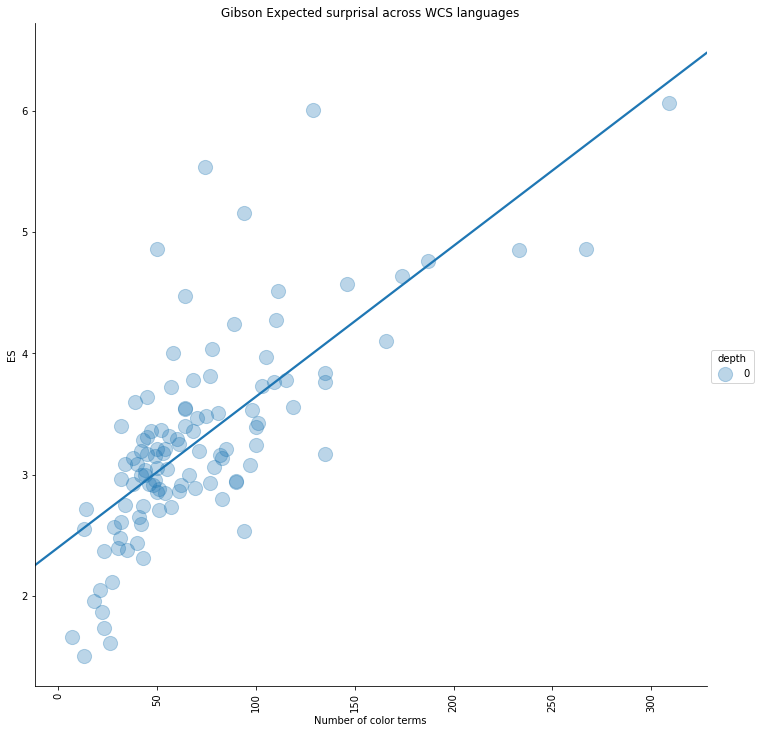

In [250]:
sns.lmplot(x='n_chips', y='ES', hue='depth', ci=None, size=10, scatter_kws={"s": 200, 'alpha':0.3}, data=df_results)
plt.title('Gibson Expected surprisal across WCS languages')
plt.ylabel('ES')
plt.xlabel('Number of color terms')
plt.xticks(rotation=90)

In [221]:
# plt.figure(figsize=(18, 9))
# colors = {d: c for d, c in zip(depths, ['red', 'blue', 'green', 'yellow', 'purple', 'orange'])}
# for d in depths:
#     df = df_results[df_results['depth']==d]
#     plt.scatter(df['n_chips'].values, df['ES'].values, color=colors[d], alpha=0.7, edgecolor='w', s=130)
# plt.title('Gibson Expected surprisal across WCS languages')
# plt.ylabel('ES')
# plt.xlabel('Number of color terms')
# plt.xticks(rotation=90)

# Rank order communicative efficiency plot

In [222]:
"""Color conversion."""
df_colors = df_raw[['chip_num', 'L', 'A', 'B']].drop_duplicates().reset_index(drop=True)
def chip2lab(chip_num):
    vals = df_colors[df_colors['chip_num']==chip_num].values[0]
    L, a, b = vals[1], vals[2], vals[3]
    return L, a, b

def lab2rgb(L, a, b):
    """Convert a single cielab to rgb."""
    lab_color = color_objects.LabColor(lab_l=L, lab_a=a, lab_b=b)
    rgb_color = color_conversions.convert_color(lab_color, color_objects.AdobeRGBColor)
    return rgb_color.get_value_tuple()

def chip2rgb(chip_num):
    """Map a WCS chip to an RGB tuple."""
    L, a, b = chip2lab(chip_num)
    R, G, B = lab2rgb(L, a, b)
    return R, G, B

def test_clab(chip_num):
    """Purely testing functionality."""
    r, g, b = chip2rgb(chip_num)
    fig, ax = plt.subplots(figsize=(2, 2))
    x = np.array([r, g, b]).reshape(1, 1, 3)
    ax.imshow(x)

In [279]:
rgb_store = []
depths = range(0, 1, 1)
d_results = []
lang_nums_used = []
min_chips = 50
for lang_num in tqdm.tqdm(languages[:N_LANGUAGES]):
    min_x = np.inf
    M, terms, chips = create_term_chip_matrix(lang_num)
    M_listener = rsa_listener(M, 1)
    M_speaker = rsa_speaker(M, 0)
    # surprisal scores
    s_cs = [s_c(M_listener, M_speaker, i) for i, c in enumerate(chips)]
    # RGBs
    chip_rgbs = [chip2rgb(c) for c in chips]
    chip_rgbs = np.array([[r, g, b] for r, g, b in chip_rgbs])
    # Sort
    sorted_data = sorted(list(zip(s_cs, chip_rgbs)), key=lambda x: x[0], reverse=True)
    sorted_rgbs = np.array([rgb for _, rgb in sorted_data])
    if sorted_rgbs.shape[0] < min_chips:
        continue
    sorted_rgbs = sorted_rgbs[:min_chips, :]
    rgb_store.append(sorted_rgbs)
    lang_nums_used.append(lang_num)
M_rgb = np.stack(rgb_store)

100%|██████████| 110/110 [01:25<00:00,  1.29it/s]


This was a little complicated, but we want to sort both the suprisal values as well as the languages.

In [280]:
# Sort
# df_results values have been sorted by average surprisal ES
idxs = np.array([v for v in df_results["lang_num"].values if v in lang_nums_used]).argsort()
rgb_store = np.array(rgb_store)  # have to convert to np array
# sort
rgb_store = rgb_store[idxs]
M_rgb = np.stack(rgb_store)

In [281]:
M_rgb_2 = []
for idx in idxs:
    M_rgb_2.append(M_rgb[idx, :, :])
M_rgb_2 = np.array(M_rgb_2)

Text(0,0.5,'Language')

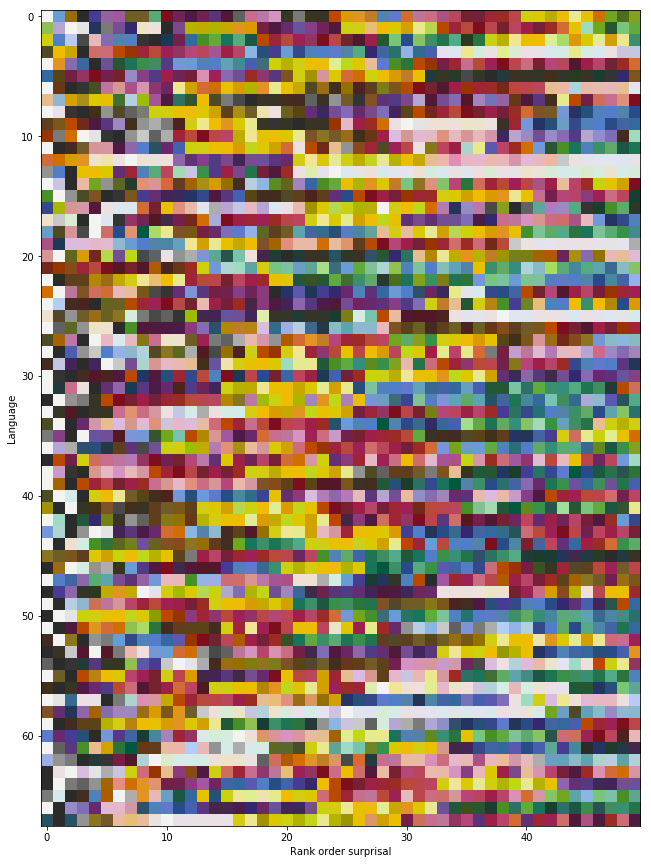

In [282]:
fig, ax = plt.subplots(figsize=(30, 15))
ax.imshow(M_rgb_2, interpolation='nearest')
ax.set_xlabel('Rank order surprisal')
ax.set_ylabel('Language')